In [14]:
import numpy as np
from scipy.optimize import minimize
from qiskit.providers.aer.noise import NoiseModel
from qiskit import *
from qiskit.extensions.standard import *
%matplotlib inline

# Find the groud state of the Hamiltonian:$H=\begin{pmatrix}
0 & 0 &0  & 0 \\
0 & -1 & 1 & 0 \\
0 & 1 & -1 & 0 \\
0 & 0 & 0 & 0
\end{pmatrix}.$

## #VQE ON A **NOISY** SIMULATOR
[See the noisless case](https://github.com/walid-mk/VQE/blob/master/Task4/VQE.Noiseless.Simulator.Code1.ipynb).


In [15]:
# preparing the wavefunction ansatz
def ansatz_init(parameters):
    circuit = QuantumCircuit(2,2)
    circuit.h(0)
    circuit.rz(parameters, 0)
    circuit.cx(0, 1)
    circuit.x(1)
    return circuit

In [16]:
def get_from(d: dict, key: str):
    value = 0
    if key in d:
        value = d[key]
    return value

&#9673; We are going to use the Qiskit Aer ```noise``` module to automatically generate a basic noise model for an IBMQ hardware device, and use this model to do noisy simulations of QuantumCircuits to see the effects of errors on the variational quantum eigensolver result.

&#9673; We will use the ```ibmq_vigo``` device. We will also want to get the ```coupling_map``` for the device from its configuration to use when compiling circuits for simulation to most closely mimic the gates that will be executed on a real device. [Source](https://github.com/Qiskit/qiskit-iqx-tutorials/blob/master/qiskit/advanced/aer/2_device_noise_simulation.ipynb)


In [18]:
provider = IBMQ.load_account()
provider.backends() ##these are the other devices that we can mimic their noises

Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [19]:
device_backend = provider.get_backend('ibmq_vigo')
coupling_map = device_backend.configuration().coupling_map
noise_model = NoiseModel.from_backend(device_backend)
basis_gates = noise_model.basis_gates

&#9673; Now that we have prepared a noisy simulator, we can run the VQE algorithm under noise

In [20]:
def vqe(parameters):
    
    # z measurement of qubit 0 and 1 
    measure_zz = QuantumCircuit(2,2)
    measure_zz.measure([0, 1], [0, 1]);

    # x measurement of qubit 0 and 1
    measure_xx = QuantumCircuit(2,2)
    measure_xx.barrier(0,1)
    measure_xx.u2(0, np.pi, 0)
    measure_xx.u2(0, np.pi, 1)
    measure_xx.measure([0, 1], [0, 1]);

    #y measurement of qubit 0 and 1
    measure_yy = QuantumCircuit(2,2)
    measure_yy.barrier(0,1)
    measure_yy.u2(0, np.pi/2, 0)
    measure_yy.u2(0, np.pi/2, 1)
    measure_yy.measure([0, 1], [0, 1]);
    
    shots = 1000 # number of samples used for statistics

    XX_YY_ZZ_expect = [] #an array that will containe the expectation value of XX,YY,ZZ -->[<XX>,<YY>,<ZZ>]
    
    # for loop that create a separate circuit for each  Pauli's matrices tensor product, 
    #calculate the expectation value of each of them, then sum up the result
    #and add 1, which correspond to the identity tensor product expectation value <II>.
    for measure_circuit in [measure_xx, measure_yy, measure_zz]:

        backend = Aer.get_backend('qasm_simulator')
        
        q = ansatz_init(parameters) + measure_circuit # wavefunction ansatz + measure_
        job = execute(q, backend, noise_model=noise_model, shots=shots, coupling_map=coupling_map, 
                      basis_gates=basis_gates)
        result = job.result()
        counts = result.get_counts()
    
        expectation_value = ((get_from(counts, '00')+get_from(counts, '11')) - 
                             (get_from(counts,'10')+get_from(counts, '01'))) / shots
    
        XX_YY_ZZ_expect.append( expectation_value )
        
    # <H> = a*<II> + b*<XX>+ c*<YY> + d*<ZZ>
    H_expect = -0.5 + 0.5*XX_YY_ZZ_expect[0] + 0.5*XX_YY_ZZ_expect[1] + 0.5*XX_YY_ZZ_expect[2]
    return H_expect

### Using the optimizer:
We run the optimizer in a noisy environment.

In [21]:
parameters = 1
tol = 1e-3 # tolerance for optimization precision.

vqe_result = minimize(vqe, parameters, method="Powell", tol=tol)

print('The estimated ground state energy from VQE algorithm is: {}'.format(vqe_result.fun))
print('The best angle for the ground state energy is: {}'.format(vqe_result.x))

The estimated ground state energy from VQE algorithm is: -1.9169999999999998
The best angle for the ground state energy is: 3.1929337658574024


### Using **```for```**  loop:
We visualize the same plot as before ( $f(angle) = expectation\;value$ ), in the presence of noise.

In [22]:
angles = np.linspace(0.0, 2.0 * np.pi, 25)

lowest_array=[] # empty regular list
for parameters in angles:
    lowest = vqe(parameters)
    lowest_array.append(lowest)
    low = np.array(lowest_array) # transformed to a numpy array

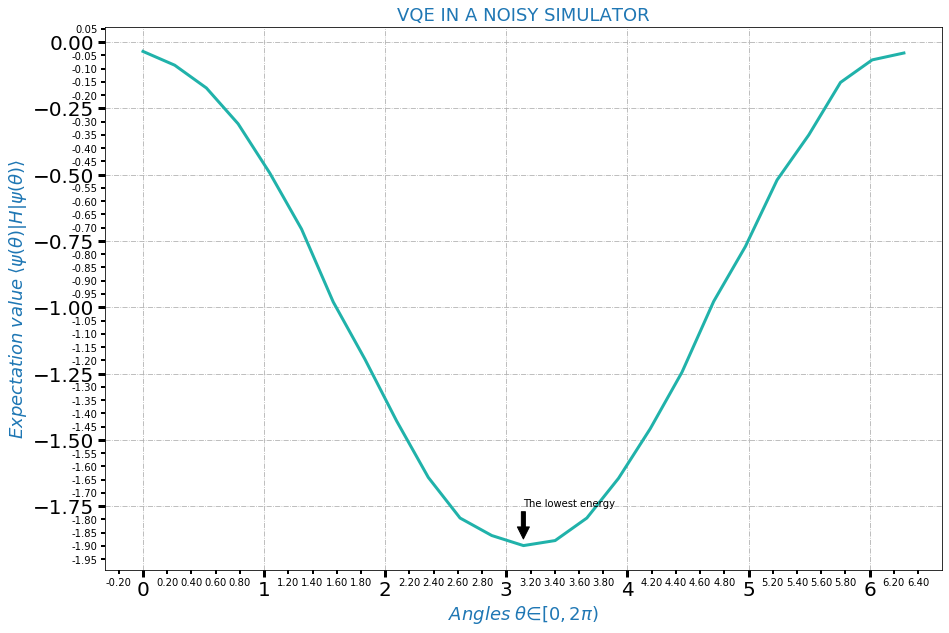

The intersection between the value of the optimizer angle and the constructed graph is the lowest energy:  -1.8952739365386408


In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator, FuncFormatter)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()
ax.plot(angles, low, linewidth=3, color='lightseagreen')


#The 3.141 position of the arrow is chosen, because It was the best angle I got after differnt execution 
#of the optimizer.
ax.annotate('The lowest energy', xy=(3.141, -1.88), xytext=(3.141, -1.75),
             arrowprops=dict(facecolor='black', shrink=0.05),)
#make the minor graduation
def minor_tick(x, pos):
    if not x % 1.0:
        return ""
    return "%.2f" % x
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.xaxis.set_minor_formatter(FuncFormatter(minor_tick))
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_formatter(FuncFormatter(minor_tick))

ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='black')
ax.tick_params(labelcolor='black', labelsize=20, width=3)

plt.xlabel(r'$Angles \; \theta ∈ [0,2\pi)$', {'color': 'C0', 'fontsize': 18})
plt.ylabel(r'$Expectation \; value \; \left\langle \psi(\theta) \right| H \left| \psi(\theta) \right\rangle$', {'color': 'C0', 'fontsize': 18})
plt.title(r'VQE IN A NOISY SIMULATOR', {'color': 'C0', 'fontsize': 18})
plt.grid(linestyle='-.')
plt.show()
# Use the interpolation numpy function, where its utilise the best angle given by the optimizer, to see if
# its give us the right ground state in Y-axis in the graph below: (f(angle) = ?)
inter = np.interp( vqe_result.x ,angles,low)
print('The intersection between the value of the optimizer angle and the constructed graph is the lowest energy: ',inter)

<b>As we can see, the plotted curve has the same general shape. And the angle in its bottom occurs close to the optimal value $\theta_{noisy} = 3.1929337658574024$, and near the one, we got with the noiseless simulator $\theta_{ideal} = 3.1042756418412325$. On the other hand, the minimum of the plot has been shifted to the expectation value $-1.8952739365386408$, which is almost equal to the value we got in the ideal case $-2.0$.

&#10173; Final results: $$\left\langle H \right\rangle_{noisy\;optim} = -2.0,\qquad \theta_{noisy\;optim} = 3.1929337658574024$$
    
$$\left\langle H \right\rangle_{noisy\;loop} = -1.90,\qquad \theta_{noisy\;loop} \approx 3.16$$